ELVES paper: https://iopscience.iop.org/article/10.3847/1538-4357/ac6fd7/meta#apjac6fd7t9

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, hstack, vstack

In [3]:
import kuaizi as kz

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

Table 4: Basic Parameters

In [5]:
cat = Table.read('./Catalog/ELVES/elves_sat.txt', 
                  format='ascii.fixed_width_no_header',
                 col_starts=(0, 15, 23, 32, 41, 47, 53, 58, 64, 69, 76,
                             83, 88, 94, 99, 105, 110, 118, 124, 130, 
                             136, 141, 146, 156),
                 )
new_cols = ['name', 'host', 'RA', 'Dec', 'Rproj', 'gmag', 'e_gmag', 
            'rimag', 'e_rimag', 'Mgmag', 'MVmag', 'e_MVmag', 'log_m_star', 
            'e_log_m_star', 'mu0V', 'e_mu0V', 're', 'e_re', 'ETG', 'Confirmed', 'Psat', 'Filt', 'Tel', 'Bad']

cat.rename_columns(cat.colnames, new_cols)

### Split into Scott's photometry + McConnachie's photometry (only V-band). For the latter, we calculate g-band photometry based on an average g-V from the former part. 

In [8]:
scott_cat = cat[cat['Tel'] != 'MCCONN']
gV = scott_cat['Mgmag'] - scott_cat['MVmag']

In [16]:
np.median(gV), np.mean(gV)

(0.28999999999999915, 0.27654911838790924)

In [33]:
# cat = cat[cat['Tel'] != 'MCCONN']

In [18]:
dist = 10**((cat['gmag'] - cat['Mgmag'] - 25) / 5)
re_ang = 206265 * cat['re'] / dist * 1e-6

In [19]:
SB_eff_g = cat['gmag'] + 2.5 * np.log10(2 * np.pi * re_ang**2)

In [20]:
cat['SB_eff_g'] = SB_eff_g
cat['dist'] = dist

In [22]:
cat[:15]

name,host,RA,Dec,Rproj,gmag,e_gmag,rimag,e_rimag,Mgmag,MVmag,e_MVmag,log_m_star,e_log_m_star,mu0V,e_mu0V,re,e_re,ETG,Confirmed,Psat,Filt,Tel,Bad,SB_eff_g,dist
str14,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,str2,str9,str3,float64,float64
M33,M31,23.4583,30.6603,205.8,--,--,--,--,--,-18.84,0.1,9.51,0.22,25.46,0.6,--,--,False,True,1.0,--,MCCONN,--,--,--
NGC205,M31,10.0917,41.6853,8.3,--,--,--,--,--,-16.48,0.1,8.78,0.22,19.2,--,589.7,24.0,True,True,1.0,--,MCCONN,--,--,--
M32,M31,10.6708,40.8653,5.5,--,--,--,--,--,-16.43,0.1,8.76,0.22,11.1,--,110.1,11.7,True,True,1.0,--,MCCONN,--,--,--
NGC147,M31,8.3,48.5089,101.8,--,--,--,--,--,-14.65,0.1,8.01,0.22,21.2,--,623.4,--,True,True,1.0,--,MCCONN,--,--,--
IC10,M31,5.0708,59.3039,259.0,--,--,--,--,--,-15.0,0.2,7.83,0.22,24.6,0.2,612.3,--,False,True,1.0,--,MCCONN,--,--,--
NGC185,M31,9.7417,48.3375,97.1,--,--,--,--,--,-14.75,0.1,8.05,0.22,20.8,--,457.4,--,True,True,1.0,--,MCCONN,--,--,--
andVII,M31,351.6292,50.6758,226.1,--,--,--,--,--,-13.21,0.3,7.39,0.22,23.2,0.2,775.9,22.2,True,True,1.0,--,MCCONN,--,--,--
andXXXII,M31,8.9975,51.5597,142.5,--,--,--,--,--,-12.25,0.7,6.98,0.22,26.4,0.8,1467.7,271.0,True,True,1.0,--,MCCONN,--,--,--
andII,M31,19.1242,33.4192,142.0,--,--,--,--,--,-12.57,0.2,7.12,0.22,24.5,0.2,1175.2,37.9,True,True,1.0,--,MCCONN,--,--,--


In [72]:
np.sum((cat['mu0V'].data.data > 24.3) & ((cat['re'].data.data + cat['e_re'].data.data) / 1000 > 1.5))

18

In [64]:
udg_flag = (cat['SB_eff_g'].data.data > 25) | ((cat['Tel'] == 'MCCONN').data & (cat['mu0V'].data.data > 24.3)) # 0.28 for gV
udg_flag &= ((cat['re'].data.data + cat['e_re'].data.data) / 1000 > 1.5)
np.sum(udg_flag)

2

In [37]:
# don't consider re error
udg_flag = (cat['SB_eff_g'].data.data > 25) | ((cat['Tel'] == 'MCCONN') & (cat['mu0V'].data.data > 24.28)) # 0.28 for gV
udg_flag &= ((cat['re'].data.data) / 1000 > 1.5)
np.sum(udg_flag)

15

Therefore, there are 15-20 UDGs in Scott's sample (444 sats in total)

4 bad photometry

Therefore should be 11 - 16 UDGs out of 429 healthy sates

In [50]:
np.sum(cat['Bad'].data.data != 'yes')

429

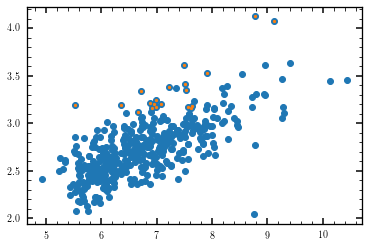

In [35]:
plt.scatter(cat['log_m_star'], np.log10(cat['re']))
plt.scatter(cat[udg_flag]['log_m_star'], np.log10(cat[udg_flag]['re']), s=5)

In [46]:
cat[udg_flag]['Psat'].mean()

0.96

---

### Host

In [97]:
host_cat = Table.read('./Catalog/ELVES/elves_host.txt', 
                      format='ascii.tab'
                 )
host_cat

Name,Dist,v _rec,${M}_{{K}_{s}}$,${M}_{{K}_{s}}^{\mathrm{group}}$,M _V,B - V,$\mathrm{log}({M}_{\star }/{M}_{\odot })$,r _cover,Data Source,References,col11
str8,float64,int64,float64,float64,float64,float64,float64,int64,str18,str27,int64
M31,0.78,-300,-24.81,-24.89,-21.19,0.87,11.01,300,M12,"CF, RC3, Sick15",--
NGC 253,3.56,259,-23.95,-23.96,-20.7,0.94,10.77,300,D- -D,"CF, Cook14a, Cook14b",--
NGC 628,9.77,656,-22.79,-22.81,-20.68,0.48,10.45,300,D-G-D,"CF, Cook14a, Cook14b",--
NGC 891,9.12,528,-23.83,-23.83,-20.05,0.82,10.84,200,C-C-C,"CF, GALEX, ${M}_{{K}_{s}}$",--
NGC 1023,10.4,638,-23.78,-23.98,-20.91,0.95,10.6,200,C-C-C,"NED, GALEX, ${M}_{{K}_{s}}$",--
NGC 1291,9.08,838,-23.94,-23.97,-21.01,1.0,10.78,300,"D-D,M-D","CF, Cook14a, Ler19",--
NGC 1808,9.29,1002,-23.12,-23.78,-19.98,0.79,10.01,300,"D-D,G,H,M-D","CF, RC3, Ler19",--
NGC 2683,9.4,409,-23.49,-23.5,-20.17,0.86,10.5,300,D-H-D,"K15, Cook14a, Ler19",--
NGC 2903,9.0,556,-23.68,-23.69,-20.78,0.65,10.67,300,"D-G,C-D","K13&T19, Cook14a, Cook14b",--


In [100]:
host_cat['${M}_{{K}_{s}}$'].data.mean()

-23.593870967741935

In [101]:
host_cat['${M}_{{K}_{s}}$'].data.std()

0.6845986694329649

(array([2., 1., 4., 8., 5., 1., 3., 4., 0., 3.]),
 array([-24.91 , -24.632, -24.354, -24.076, -23.798, -23.52 , -23.242,
        -22.964, -22.686, -22.408, -22.13 ]),
 <BarContainer object of 10 artists>)

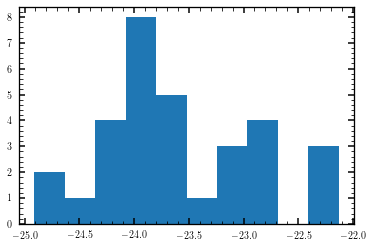

In [99]:
plt.hist(host_cat['${M}_{{K}_{s}}$'].data)